<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development


### Inizializzazione

In [25]:
# Gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import math
import shutil
import joblib
from scipy.special import comb
from collections import defaultdict

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning e metriche
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    log_loss,
    f1_score,
)

# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Concatenate,
    Masking,
    Embedding,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences

# Scaler fixed for non binary values
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib


In [26]:
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,is_final,final_set,opponent_final_set,player_points,set_result,last_comeback,points_diff,points_length
0,1,0,0,"[0, 0, 1, 1, 0, 1, 1]",0,2,1,7
1,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",0,-1,0,8
2,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",0,-2,-1,9
3,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",0,1,0,10
4,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",0,2,1,11
...,...,...,...,...,...,...,...,...
978595,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1]",1,5,3,9
978596,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]",1,-1,3,11
978597,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]",1,-2,2,12
978598,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]",1,1,3,13


Funzione che procede alla eliminazione dei folder quando è necessario

In [27]:
# Funzione per eliminare cartelle specificate
def delete_folders(folders):
    for folder in folders:
        if os.path.exists(folder):
            try:
                shutil.rmtree(folder)  # Rimuove la cartella e tutto il suo contenuto
                print(f"La cartella '{folder}' è stata eliminata.")
            except Exception as e:
                print(f"Errore durante l'eliminazione della cartella '{folder}': {e}")
        else:
            print(f"La cartella '{folder}' non esiste.")

# Lista delle cartelle da eliminare
folders_to_delete = ['/content/datasets', '/content/split_datasets', '/content/opponent_datasets','/content/merged_datasets']

# Esegui la funzione per eliminare le cartelle
delete_folders(folders_to_delete)


La cartella '/content/datasets' è stata eliminata.
La cartella '/content/split_datasets' è stata eliminata.
La cartella '/content/opponent_datasets' è stata eliminata.
La cartella '/content/merged_datasets' è stata eliminata.


Suddivisione del dataset iniziale in numerosi dataset sulla base delle istanze dei punteggi

In [28]:
# Funzione per calcolare la combinazione di punteggi
def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"

# Funzione per creare i dataset separati in base alla combinazione di punteggi
def create_datasets_by_score_combinations(df):
    # Applica la funzione `extract_scores` per ottenere le combinazioni di punteggi
    score_combinations = df['player_points'].apply(extract_scores)

    # Inizializza un dizionario per memorizzare i dataset
    datasets = defaultdict(list)

    # Raggruppa le righe in base alla combinazione di punteggi
    for index, row in df.iterrows():
        score_combination = score_combinations[index]
        datasets[score_combination].append(row)

    # Crea un dataframe per ogni combinazione di punteggi
    result_datasets = {}
    for score_combination, rows in datasets.items():
        result_datasets[score_combination] = pd.DataFrame(rows)

    return result_datasets

# Funzione per salvare i dataset in una cartella
def save_datasets_to_folder(datasets, folder_path):
    # Crea la cartella se non esiste
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Salva ogni dataset in un file CSV
    for score_combination, dataset in datasets.items():
        # Conta il numero di righe nel dataset
        num_rows = len(dataset)

        # Usa "dataset_" come prefisso e la combinazione di punteggi come parte del nome
        filename = f"{score_combination}.csv"
        filepath = os.path.join(folder_path, filename)

        # Salva il dataset nel file CSV
        dataset.to_csv(filepath, index=False)

        # Stampa il numero di righe per ciascun dataset
        print(f"Dataset per la combinazione {score_combination} salvato in {filepath} con {num_rows} righe.")

# Esegui la funzione sul dataset
result_datasets = create_datasets_by_score_combinations(dataset)

# Specifica la cartella dove salvare i file
folder_path = '/content/datasets'

# Salva i dataset separati nella cartella
save_datasets_to_folder(result_datasets, folder_path)



Dataset per la combinazione 4-3 salvato in /content/datasets/4-3.csv con 36116 righe.
Dataset per la combinazione 4-4 salvato in /content/datasets/4-4.csv con 35292 righe.
Dataset per la combinazione 4-5 salvato in /content/datasets/4-5.csv con 31964 righe.
Dataset per la combinazione 5-5 salvato in /content/datasets/5-5.csv con 31468 righe.
Dataset per la combinazione 6-5 salvato in /content/datasets/6-5.csv con 28743 righe.
Dataset per la combinazione 6-6 salvato in /content/datasets/6-6.csv con 28512 righe.
Dataset per la combinazione 6-7 salvato in /content/datasets/6-7.csv con 26382 righe.
Dataset per la combinazione 6-8 salvato in /content/datasets/6-8.csv con 23306 righe.
Dataset per la combinazione 6-9 salvato in /content/datasets/6-9.csv con 20034 righe.
Dataset per la combinazione 7-9 salvato in /content/datasets/7-9.csv con 21905 righe.
Dataset per la combinazione 3-4 salvato in /content/datasets/3-4.csv con 36116 righe.
Dataset per la combinazione 5-4 salvato in /content/da

Verifica dei numeri

In [29]:

def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"
# Funzione principale che calcola e ritorna le combinazioni di punteggio
def count_score_combinations(dataframe):
    # Calcola le combinazioni senza aggiungerle al dataframe
    score_combinations = dataframe['player_points'].apply(extract_scores)

    # Conta le occorrenze di ciascuna combinazione
    return score_combinations.value_counts()

# Calcolo e stampa delle combinazioni
score_count = count_score_combinations(dataset)
print(score_count)

player_points
4-3    36116
3-4    36116
4-4    35292
4-5    31964
5-4    31964
5-5    31468
3-5    29599
5-3    29599
5-6    28743
6-5    28743
6-6    28512
6-4    27082
4-6    27082
6-7    26382
7-6    26382
7-7    26102
7-5    24967
5-7    24967
7-8    24232
8-7    24232
8-8    23584
6-8    23306
8-6    23306
5-2    23243
2-5    23243
6-3    22782
3-6    22782
9-8    22344
8-9    22344
7-4    22165
4-7    22165
9-7    21905
7-9    21905
9-9    21904
5-8    21005
8-5    21005
9-6    20034
6-9    20034
Name: count, dtype: int64


In [30]:
# Funzione per fare il train-test split sui file CSV
def split_train_test_for_csv_files(input_folder, output_folder, test_size=0.2, random_state=42):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella di input
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            # Costruisci il percorso completo del file CSV
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV in un DataFrame
            df = pd.read_csv(file_path)

            # Suddividi il dataset in training e test (80/20)
            train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

            # Crea i nomi dei file per il training e il test
            train_filename = file_name.replace(".csv", "_train.csv")
            test_filename = file_name.replace(".csv", "_test.csv")

            # Costruisci i percorsi per i file di training e test
            train_filepath = os.path.join(output_folder, train_filename)
            test_filepath = os.path.join(output_folder, test_filename)

            # Salva i dati di training e test in nuovi file CSV
            train_data.to_csv(train_filepath, index=False)
            test_data.to_csv(test_filepath, index=False)

            # Stampa il risultato
            print(f"File '{file_name}' diviso in {train_filename} e {test_filename}.")
            print(f"  - {len(train_data)} righe per il training.")
            print(f"  - {len(test_data)} righe per il test.")

# Esegui la funzione per suddividere i dataset
input_folder = '/content/datasets'  # Cartella dove sono i file CSV originali
output_folder = '/content/split_datasets'  # Cartella dove salvare i file divisi

split_train_test_for_csv_files(input_folder, output_folder)


File '3-6.csv' diviso in 3-6_train.csv e 3-6_test.csv.
  - 18225 righe per il training.
  - 4557 righe per il test.
File '8-7.csv' diviso in 8-7_train.csv e 8-7_test.csv.
  - 19385 righe per il training.
  - 4847 righe per il test.
File '4-3.csv' diviso in 4-3_train.csv e 4-3_test.csv.
  - 28892 righe per il training.
  - 7224 righe per il test.
File '6-8.csv' diviso in 6-8_train.csv e 6-8_test.csv.
  - 18644 righe per il training.
  - 4662 righe per il test.
File '7-4.csv' diviso in 7-4_train.csv e 7-4_test.csv.
  - 17732 righe per il training.
  - 4433 righe per il test.
File '4-7.csv' diviso in 4-7_train.csv e 4-7_test.csv.
  - 17732 righe per il training.
  - 4433 righe per il test.
File '6-9.csv' diviso in 6-9_train.csv e 6-9_test.csv.
  - 16027 righe per il training.
  - 4007 righe per il test.
File '6-5.csv' diviso in 6-5_train.csv e 6-5_test.csv.
  - 22994 righe per il training.
  - 5749 righe per il test.
File '4-6.csv' diviso in 4-6_train.csv e 4-6_test.csv.
  - 21665 righe p

In [31]:
# Funzione per creare il dataset "opposite" (opponent) modificato
def create_opponent_dataset(df):
    # Copia del dataframe originale per non modificarlo direttamente
    opponent_df = df.copy()

    # 1. Scambia 'final_set' e 'opponent_final_set'
    opponent_df['final_set'], opponent_df['opponent_final_set'] = opponent_df['opponent_final_set'], opponent_df['final_set']

    # 2. Scambia i valori in 'player_points'
    opponent_df['player_points'] = opponent_df['player_points'].apply(lambda points: [1 - p for p in ast.literal_eval(points)])

    # 3. Scambia 'set_result' (0 diventa 1 e viceversa)
    opponent_df['set_result'] = opponent_df['set_result'].apply(lambda x: 1 - x)

    # 4. Inverti 'last_come_back' e 'point_diff' (positivi diventano negativi e viceversa)
    opponent_df['last_comeback'] = opponent_df['last_comeback'].apply(lambda x: -x)
    opponent_df['points_diff'] = opponent_df['points_diff'].apply(lambda x: -x)

    return opponent_df

# Funzione per caricare e modificare i dataset separati in training e test
def create_opponent_datasets(input_folder, output_folder):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella di input
    for file_name in os.listdir(input_folder):
        if file_name.endswith("_train.csv") or file_name.endswith("_test.csv"):
            # Costruisci il percorso completo del file CSV
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV in un DataFrame
            df = pd.read_csv(file_path)

            # Crea il dataset "opponent"
            opponent_df = create_opponent_dataset(df)

            # Estrai il punteggio dal nome del file (ad esempio '5-3_train.csv' -> '5-3')
            base_name = file_name.split('_')[0]  # '5-3' da '5-3_train.csv'

            # Inverti i numeri (ad esempio '5-3' -> '3-5')
            inverted_score = '-'.join(base_name.split('-')[::-1])  # '5-3' -> '3-5'

            # Crea il nuovo nome del file aggiungendo '_opp'
            opponent_filename = f"{inverted_score}_train_opp.csv" if "_train" in file_name else f"{inverted_score}_test_opp.csv"

            # Percorso completo del nuovo file
            opponent_filepath = os.path.join(output_folder, opponent_filename)

            # Salva il nuovo dataset "opponent"
            opponent_df.to_csv(opponent_filepath, index=False)

            # Stampa il risultato
            print(f"File '{file_name}' trasformato in '{opponent_filename}'.")

# Esegui la funzione per creare i dataset "opponent"
input_folder = '/content/split_datasets'  # Cartella con i file CSV separati per training e test
output_folder = '/content/opponent_datasets'  # Cartella dove salvare i file trasformati

create_opponent_datasets(input_folder, output_folder)



File '8-6_test.csv' trasformato in '6-8_test_opp.csv'.
File '6-3_train.csv' trasformato in '3-6_train_opp.csv'.
File '4-5_test.csv' trasformato in '5-4_test_opp.csv'.
File '7-9_train.csv' trasformato in '9-7_train_opp.csv'.
File '6-8_train.csv' trasformato in '8-6_train_opp.csv'.
File '6-4_test.csv' trasformato in '4-6_test_opp.csv'.
File '7-8_test.csv' trasformato in '8-7_test_opp.csv'.
File '7-4_test.csv' trasformato in '4-7_test_opp.csv'.
File '5-6_train.csv' trasformato in '6-5_train_opp.csv'.
File '6-7_test.csv' trasformato in '7-6_test_opp.csv'.
File '4-7_test.csv' trasformato in '7-4_test_opp.csv'.
File '5-5_test.csv' trasformato in '5-5_test_opp.csv'.
File '6-5_test.csv' trasformato in '5-6_test_opp.csv'.
File '7-5_train.csv' trasformato in '5-7_train_opp.csv'.
File '4-4_train.csv' trasformato in '4-4_train_opp.csv'.
File '9-7_train.csv' trasformato in '7-9_train_opp.csv'.
File '5-7_test.csv' trasformato in '7-5_test_opp.csv'.
File '9-9_train.csv' trasformato in '9-9_train_opp.

In [32]:

# Funzione per unire i dataset originali con quelli "opponent"
def merge_datasets(original_folder, opponent_folder, output_folder):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella degli originali (train e test)
    original_train_files = {f.replace("_train.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_train.csv")}
    opponent_train_files = {f.replace("_train_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_train_opp.csv")}

    original_test_files = {f.replace("_test.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_test.csv")}
    opponent_test_files = {f.replace("_test_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_test_opp.csv")}

    # Unisci i file per il training
    for base_name, original_file in original_train_files.items():
        opponent_file = opponent_train_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            # Leggi i file CSV in DataFrame
            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            # Unisci i due DataFrame
            merged_train_df = pd.concat([original_df, opponent_df], ignore_index=True)

            # Salva il nuovo dataset unito
            merged_train_filename = f"merged_{original_file}"
            merged_train_filepath = os.path.join(output_folder, merged_train_filename)
            merged_train_df.to_csv(merged_train_filepath, index=False)

            # Stampa il risultato
            print(f"Unito '{original_file}' e '{opponent_file}' in '{merged_train_filename}'.")

    # Unisci i file per il test
    for base_name, original_file in original_test_files.items():
        opponent_file = opponent_test_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            # Leggi i file CSV in DataFrame
            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            # Unisci i due DataFrame
            merged_test_df = pd.concat([original_df, opponent_df], ignore_index=True)

            # Salva il nuovo dataset unito
            merged_test_filename = f"merged_{original_file}"
            merged_test_filepath = os.path.join(output_folder, merged_test_filename)
            merged_test_df.to_csv(merged_test_filepath, index=False)

            # Stampa il risultato
            print(f"Unito '{original_file}' e '{opponent_file}' in '{merged_test_filename}'.")

# Esegui la funzione per unire i dataset
original_folder = '/content/split_datasets'  # Cartella con i file originali (train e test)
opponent_folder = '/content/opponent_datasets'  # Cartella con i file degli opponent (train_opp e test_opp)
output_folder = '/content/merged_datasets'  # Cartella dove salvare i file uniti

merge_datasets(original_folder, opponent_folder, output_folder)


Unito '6-3_train.csv' e '6-3_train_opp.csv' in 'merged_6-3_train.csv'.
Unito '7-9_train.csv' e '7-9_train_opp.csv' in 'merged_7-9_train.csv'.
Unito '6-8_train.csv' e '6-8_train_opp.csv' in 'merged_6-8_train.csv'.
Unito '5-6_train.csv' e '5-6_train_opp.csv' in 'merged_5-6_train.csv'.
Unito '7-5_train.csv' e '7-5_train_opp.csv' in 'merged_7-5_train.csv'.
Unito '4-4_train.csv' e '4-4_train_opp.csv' in 'merged_4-4_train.csv'.
Unito '9-7_train.csv' e '9-7_train_opp.csv' in 'merged_9-7_train.csv'.
Unito '9-9_train.csv' e '9-9_train_opp.csv' in 'merged_9-9_train.csv'.
Unito '5-2_train.csv' e '5-2_train_opp.csv' in 'merged_5-2_train.csv'.
Unito '6-7_train.csv' e '6-7_train_opp.csv' in 'merged_6-7_train.csv'.
Unito '6-4_train.csv' e '6-4_train_opp.csv' in 'merged_6-4_train.csv'.
Unito '6-5_train.csv' e '6-5_train_opp.csv' in 'merged_6-5_train.csv'.
Unito '8-7_train.csv' e '8-7_train_opp.csv' in 'merged_8-7_train.csv'.
Unito '9-6_train.csv' e '9-6_train_opp.csv' in 'merged_9-6_train.csv'.
Unito 

### Logistic Regression

In [ ]:
# Selezioniamo le feature numeriche e binarie
numeric_columns = ['last_comeback', 'points_diff', 'points_length']
X_numeric = dataset[numeric_columns].values

binary_columns = ['is_final', 'final_set', 'opponent_final_set']
X_binary = dataset[binary_columns].values

# Target binario
Y = dataset['set_result'].values

# Suddivisione del dataset in training e test set
X_train_numeric, X_test_numeric, X_train_binary, X_test_binary, Y_train, Y_test = train_test_split(
    X_numeric, X_binary, Y, test_size=0.2, random_state=42
)

# Normalizzazione delle variabili numeriche
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)  # Normalizzazione dei dati di training
X_test_numeric_scaled = scaler.transform(X_test_numeric)  # Usa solo transform sui dati di test

# Concatenazione delle variabili numeriche scalate con quelle binarie
X_train_final = np.hstack([X_train_numeric_scaled, X_train_binary])
X_test_final = np.hstack([X_test_numeric_scaled, X_test_binary])

# Verifica del risultato
print("Shape of X_train_final:", X_train_final.shape)
print("Shape of X_test_final:", X_test_final.shape)

NameError: name 'dataset' is not defined

In [ ]:
# Logistic Regression con L1
log_reg_l1 = LogisticRegression(max_iter=1000, random_state=42)
log_reg_l1.fit(X_train_final, Y_train)

# Previsione sui dati di test
y_pred_l1 = log_reg_l1.predict(X_test_final)

# Calcolare l'accuratezza sui dati di test
print("Logistic Regression L1 Accuracy:", accuracy_score(Y_test, y_pred_l1))

Logistic Regression L1 Accuracy: 0.7001443739444986


In [ ]:
def process_sequence(points):
    """Calcola le statistiche per una sequenza di punti, come la rimonta, i punteggi, etc."""
    max_rimonta_a = 0
    max_rimonta_b = 0
    rimonta_a = 0
    rimonta_b = 0
    punti_a = 0
    punti_b = 0

    for point in points:
        if point == 1:
            rimonta_a += 1
            rimonta_b = 0
            max_rimonta_a = max(max_rimonta_a, rimonta_a)
            punti_a += 1
        elif point == 0:
            rimonta_b += 1
            rimonta_a = 0
            max_rimonta_b = max(max_rimonta_b, rimonta_b)
            punti_b += 1

    # Restituisce un dizionario con le caratteristiche numeriche
    return {
        'rimonta_diff': rimonta_a-rimonta_b,
        'punteggi_diff': punti_a-punti_b,
        'sequence_length': punti_b+punti_a
    }

def extract_features(sequences):
    """Estrai le caratteristiche numeriche e binarie da una lista di sequenze."""
    features = []
    for points in sequences:
        numeric_features = process_sequence(points)
        # Aggiungiamo le caratteristiche numeriche
        numeric_values = list(numeric_features.values())

        # Aggiungi le caratteristiche binarie (modifica in base ai tuoi dati)
        binary_features = [1, 0, 0]  # Aggiungi o modifica secondo necessità

        # Combina le caratteristiche numeriche e binarie
        features.append(numeric_values + binary_features)

    return np.array(features)

def scale_features(X_train_numeric, test_sequences_final):
    """Scalare solo le caratteristiche numeriche."""
    numeric_columns_count = len(test_sequences_final[0]) - 6  # Escludi le caratteristiche binarie
    scaler = StandardScaler()

    # Adattiamo lo scaler ai dati di addestramento per evitare data leakage
    scaler.fit(X_train_numeric)

    # Separiamo le caratteristiche numeriche dalle binarie
    numeric_data = test_sequences_final[:, :numeric_columns_count]
    binary_data = test_sequences_final[:, numeric_columns_count:]

    # Scaliamo solo le caratteristiche numeriche
    numeric_data_scaled = scaler.transform(numeric_data)

    # Concatenare i dati numerici scalati con i dati binari
    test_sequences_scaled = np.hstack((numeric_data_scaled, binary_data))

    return test_sequences_scaled

def predict_probabilities(log_reg_model, test_sequences_scaled):
    """Fai una previsione con il modello di regressione logistica per tutte le sequenze."""
    probabilita = log_reg_model.predict_proba(test_sequences_scaled)
    return probabilita[:, 1]  # Restituisce le probabilità per la classe 1


# Dati di test (esempio)
test_sequences = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],  # Esempio 1
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Esempio 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
]

# Step 1: Estrai le caratteristiche numeriche e binarie dalle sequenze
test_sequences_final = extract_features(test_sequences)

# Step 2: Scala le caratteristiche numeriche
# Supponiamo che X_train_numeric sia già definito da precedenti dati di addestramento
test_sequences_scaled = scale_features(X_train_numeric, test_sequences_final)
# Step 3: Prevedi le probabilità per tutte le sequenze
probabilita = predict_probabilities(log_reg_l1, test_sequences_scaled)

print("Predictions with input features:\n")
for i, (prob, sequence, features) in enumerate(zip(probabilita, test_sequences, test_sequences_scaled)):
    print(f"Instance {i+1}:")
    print(f"  Original Sequence: {sequence}")
    print(f"  Input to Model: {features}")
    print(f"  Predicted Probability: {prob:.4f}")
    print("-" * 80)

Predictions with input features:

Instance 1:
  Original Sequence: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
  Input to Model: [ 1  0  0  1  0  0 -2  0 10]
  Predicted Probability: 0.6148
--------------------------------------------------------------------------------
Instance 2:
  Original Sequence: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
  Input to Model: [ 1  0  0  1  0  0  5  0 10]
  Predicted Probability: 0.5465
--------------------------------------------------------------------------------
Instance 3:
  Original Sequence: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
  Input to Model: [ 1  0  0  1  0  0 -5  0 10]
  Predicted Probability: 0.4911
--------------------------------------------------------------------------------
Instance 4:
  Original Sequence: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
  Input to Model: [ 1  0  0  1  0  0  1  1 11]
  Predicted Probability: 0.5674
--------------------------------------------------------------------------------
Instance 5:
  Original Sequence: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


### XGboost Random Forest

In [ ]:
from xgboost import XGBClassifier
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

# Concatenazione delle variabili numeriche scalate con quelle binarie
X_train_final = np.hstack([X_train_numeric_scaled, X_train_binary])
X_test_final = np.hstack([X_test_numeric_scaled, X_test_binary])

# Crea il modello XGBoost
xgboost = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Allena il modello
xgboost.fit(X_train_final, Y_train)

# Predizioni
y_pred_xgb = xgboost.predict(X_test_final)

# Valuta la performance
print("XGBoost Accuracy:", accuracy_score(Y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:48:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6997714523166424


### SVM

In [ ]:
scaler_svm = StandardScaler()

# Applichiamo lo scaling sui dati numerici per entrambi i set di addestramento e test
X_train_numeric_scaled_svm = scaler_svm.fit_transform(X_train_numeric)
X_test_numeric_scaled_svm = scaler_svm.transform(X_test_numeric)

# Concatenare le variabili numeriche scalate con le variabili binarie non scalate
X_train_final_svm = np.hstack([X_train_numeric_scaled_svm, X_train_binary])
X_test_final_svm = np.hstack([X_test_numeric_scaled_svm, X_test_binary])

# 1. Linear Kernel SVM
svm_linear = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_linear.fit(X_train_final_svm, Y_train)
joblib.dump(svm_linear, 'svm_linear_model.pkl')

# Predizioni e probabilità
y_pred_linear = svm_linear.predict(X_test_final_svm)
y_pred_proba_linear = svm_linear.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("Linear Kernel Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("Linear Kernel Probabilities:", y_pred_proba_linear)

# 2. RBF Kernel SVM
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm_rbf.fit(X_train_final_svm, Y_train)
joblib.dump(svm_rbf, 'svm_rbf_model.pkl')

# Predizioni e probabilità
y_pred_rbf = svm_rbf.predict(X_test_final_svm)
y_pred_proba_rbf = svm_rbf.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("RBF Kernel Accuracy:", accuracy_score(Y_test, y_pred_rbf))
print("RBF Kernel Probabilities:", y_pred_proba_rbf)

# 3. Polynomial Kernel SVM
svm_poly = SVC(kernel='poly', C=1.0, degree=3, random_state=42, probability=True)
svm_poly.fit(X_train_final_svm, Y_train)
joblib.dump(svm_poly, 'svm_poly_model.pkl')

# Predizioni e probabilità
y_pred_poly = svm_poly.predict(X_test_final_svm)
y_pred_proba_poly = svm_poly.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("Polynomial Kernel Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("Polynomial Kernel Probabilities:", y_pred_proba_poly)

# 4. Sigmoid Kernel SVM
svm_sigmoid = SVC(kernel='sigmoid', C=1.0, random_state=42, probability=True)
svm_sigmoid.fit(X_train_final_svm, Y_train)
joblib.dump(svm_sigmoid, 'svm_sigmoid_model.pkl')

# Predizioni e probabilità
y_pred_sigmoid = svm_sigmoid.predict(X_test_final_svm)
y_pred_proba_sigmoid = svm_sigmoid.predict_proba(X_test_final_svm)[:, 1]  # Probability for class 1

print("Sigmoid Kernel Accuracy:", accuracy_score(Y_test, y_pred_sigmoid))
print("Sigmoid Kernel Probabilities:", y_pred_proba_sigmoid)

#### Cross validation

In [ ]:
X = np.array((dataset[['is_final', 'final_set', 'opponent_final_set']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# K-Fold Cross Validation
logreg_model_kf = LogisticRegression(max_iter=1000, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_kf = []
classification_reports_kf = []
roc_auc_kf = []
log_losses_kf = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Addestramento
    logreg_model_kf.fit(X_train, Y_train)

    # Predizioni
    Y_pred = logreg_model_kf.predict(X_test)
    Y_pred_prob = logreg_model_kf.predict_proba(X_test)

    # Valutazione
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies_kf.append(accuracy)
    classification_reports_kf.append(classification_report(Y_test, Y_pred))

    # ROC Curve e AUC
    fpr_kf, tpr_kf, _ = roc_curve(Y_test, Y_pred_prob[:, 1])
    roc_auc = auc(fpr_kf, tpr_kf)
    roc_auc_kf.append(roc_auc)

    # Log Loss
    log_loss_value = log_loss(Y_test, Y_pred_prob)
    log_losses_kf.append(log_loss_value)

# Media delle performance
mean_accuracy_kf = np.mean(accuracies_kf)
mean_roc_auc_kf = np.mean(roc_auc_kf)
mean_log_loss_kf = np.mean(log_losses_kf)

print(f"Accuratezza media K-Fold: {mean_accuracy_kf:.2f}")
print(f"AUC media K-Fold: {mean_roc_auc_kf:.2f}")
print(f"Log Loss medio K-Fold: {mean_log_loss_kf:.2f}")

Accuratezza media K-Fold: 0.79
AUC media K-Fold: 0.88
Log Loss medio K-Fold: 0.44


### Random Forest

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','rimonta_corrente_diff', 'punteggi_diff', 'sequence_length']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

rf.fit(X_train, Y_train)

# Nomi delle feature
feature_names = ['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final','final_set', 'opponent_final_set','rimonta_corrente_diff', 'punteggi_diff', 'sequence_length']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

In [ ]:
X = np.array((dataset[['max_rimonta_a', 'max_rimonta_b', 'rimonta_corrente_a', 'rimonta_corrente_b', 'punti_a',	'punti_b']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

rf.fit(X_train, Y_train)

# Nomi delle feature
feature_names = ['max_rimonta_a', 'max_rimonta_b', 'rimonta_corrente_a', 'rimonta_corrente_b', 'punti_a',	'punti_b']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

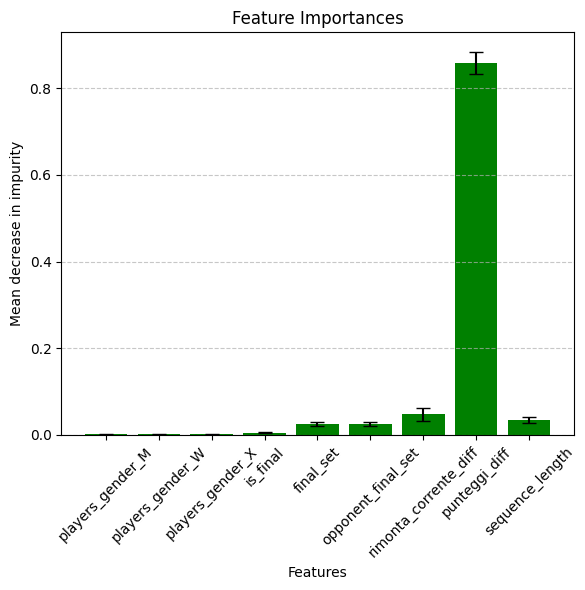

In [ ]:
# Grafico con barre e barre d'errore
plt.figure(figsize=(6, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
'''
vedo l'importanza di ciascun punto per ogni tipologia di set
11-0 , 11-1,.....,11-9

DECIDI SE CANCELLARLO E CONSIDERARE SOLO LE FEATURE USATE NEL LOGISTIC REGRESSION
'''


# Paddiamo tutte le sequenze di player_points in anticipo
player_points_padded = pad_sequences(dataset['player_points'], padding='post', truncating='post', value=-1)

# Utilizziamo solo player_points come feature, senza altre colonne
X = player_points_padded

# Target binario Y
Y = np.array(dataset['set_result'].values)

# Creiamo il modello di Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Itera su ogni possibile lunghezza di player_points da 10 a 19
for length in range(10, 20):
    # Filtra il dataset per includere solo i dati con player_points di lunghezza 'length'

    indices = np.where([len(points) == length for points in dataset['player_points']])[0]

    # Seleziona X e Y per gli indici selezionati
    X_subset = X[indices]
    Y_subset = Y[indices]

    # Suddividi il dataset in train-test (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42, stratify=Y_subset)

    # Allena il modello sui dati di addestramento
    rf_model.fit(X_train, Y_train)

    # Estrai l'importanza delle feature per questo modello
    importances = rf_model.feature_importances_

    importances_trimmed = importances[:length]
    print(len(importances_trimmed))
    # Nomi delle feature (solo player_point_1, player_point_2, ..., player_point_19)
    feature_names = [f'player_point_{i}' for i in range(1, length+1)]


    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

### LSTM

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

In [ ]:
# Verifichiamo che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)

# Effettuiamo il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=18, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=18, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
history = model.fit(X_train, Y_train, epochs=5, batch_size=64)

Epoch 1/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 202s 30ms/step - accuracy: 0.7382 - loss: 0.5319
Epoch 2/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 188s 29ms/step - accuracy: 0.7467 - loss: 0.5171
Epoch 3/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 227s 33ms/step - accuracy: 0.7448 - loss: 0.5179
Epoch 4/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 228s 28ms/step - accuracy: 0.7461 - loss: 0.5154
Epoch 5/5
6444/6444 ━━━━━━━━━━━━━━━━━━━━ 177s 28ms/step - accuracy: 0.7474 - loss: 0.5135


In [ ]:
model.save('model182.keras')

In [ ]:
y_pred_prob = model.predict(X_test)  # Previsioni probabilistiche
y_pred = (y_pred_prob > 0.5).astype(int)  # Converti in classi binarie (0 o 1)

# Calcola l'accuratezza del modello
accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Matrice di confusione
cm = confusion_matrix(Y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Report di classificazione (precisione, recall, f1-score)
report = classification_report(Y_test, y_pred)
print('Classification Report:')
print(report)

# Valutazione del modello
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

3222/3222 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step
Accuracy: 0.7474
Confusion Matrix:
[[42211  9338]
 [16705 34843]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76     51549
           1       0.79      0.68      0.73     51548

    accuracy                           0.75    103097
   macro avg       0.75      0.75      0.75    103097
weighted avg       0.75      0.75      0.75    103097

3222/3222 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.7483 - loss: 0.5119
Test Loss: 0.5118
Test Accuracy: 0.7474


In [ ]:
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],  # Esempio 1
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Esempio 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
]

# Effettua il padding delle sequenze di input
X_new = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Prevedi le probabilità usando il modello
y_pred_prob_new = model.predict(X_new)

# Convertili in etichette binarie
y_pred_new = (y_pred_prob_new > 0.5).astype(int)

# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print(f"Predizione (classe): {y_pred_new[i][0]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Esempio 1: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Probabilità previste: 0.5167
Predizione (classe): 1
--------------------------------------------------
Esempio 2: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Probabilità previste: 0.5373
Predizione (classe): 1
--------------------------------------------------
Esempio 3: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.4895
Predizione (classe): 0
--------------------------------------------------
Esempio 4: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Probabilità previste: 0.6724
Predizione (classe): 1
--------------------------------------------------
Esempio 5: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Probabilità previste: 0.6920
Predizione (classe): 1
--------------------------------------------------
Esempio 6: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.6414
Predizione (classe): 1
--------------------------------------------------
Esempio 7: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Probabilità previste: 0.7835
Predizione 

In [ ]:
from tensorflow.keras.models import load_model
model= load_model("model18NewDataset.keras")

In [ ]:
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1,0,0],  # Esempio 1
    [0, 0, 0,0,0 ,1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 0, 0, 0,0,0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1,0,0,1],  # Esempio 1
    [0, 0, 0,0,0 ,1, 1, 1, 1, 1,1],  # Esempio 2
    [1, 1, 1, 1, 1,1, 0, 0, 0,0,0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1,1,0],  # Esempio 1
    [0, 0, 0,0 ,1, 1, 1, 1, 1,1],  # Esempio 2
    [1, 1, 1, 1, 1, 1, 0, 0,0,0],  # Esempio 3
]

# Effettua il padding delle sequenze di input
X_new = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Prevedi le probabilità usando il modello
y_pred_prob_new = model.predict(X_new)

# Convertili in etichette binarie
y_pred_new = (y_pred_prob_new > 0.5).astype(int)

# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print(f"Predizione (classe): {y_pred_new[i][0]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Esempio 1: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Probabilità previste: 0.5167
Predizione (classe): 1
--------------------------------------------------
Esempio 2: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Probabilità previste: 0.5373
Predizione (classe): 1
--------------------------------------------------
Esempio 3: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.4895
Predizione (classe): 0
--------------------------------------------------
Esempio 4: [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Probabilità previste: 0.6724
Predizione (classe): 1
--------------------------------------------------
Esempio 5: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Probabilità previste: 0.6920
Predizione (classe): 1
--------------------------------------------------
Esempio 6: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Probabilità previste: 0.6414
Predizione (classe): 1
--------------------------------------------------
Esempio 7: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Probabilità previste: 0.7835
Predizione 

In [ ]:
from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Probabilità di vincere un punto
p = 0.5

# Lista per raccogliere i risultati
results = []

# Calcoliamo la probabilità per tutte le combinazioni di x e y con x <= 10 e y <= 10
for x in range(0, 11):  # x va da 0 a 10
    for y in range(0, 11):  # y va da 0 a 10
        if x + y >= 7:  # Condizione che x + y deve essere maggiore o uguale a 7
            result = prob(p, x, y)
            if 0.1 < result < 0.9:  # La probabilità deve essere compresa tra 0.1 e 0.9
                results.append((x, y, result))

# Ordinare i risultati in base alla probabilità
results.sort(key=lambda x: x[2])  # Ordinamento in base al terzo elemento (probabilità)

# Stampare i risultati ordinati
for x, y, result in results:
    print(f"Probabilità per x={x}, y={y}: {result}")


Probabilità per x=6, y=9: 0.109375
Probabilità per x=3, y=7: 0.11328125
Probabilità per x=8, y=10: 0.125
Probabilità per x=2, y=6: 0.1334228515625
Probabilità per x=5, y=8: 0.14453125
Probabilità per x=4, y=7: 0.171875
Probabilità per x=7, y=9: 0.1875
Probabilità per x=3, y=6: 0.19384765625
Probabilità per x=2, y=5: 0.21197509765625
Probabilità per x=6, y=8: 0.2265625
Probabilità per x=9, y=10: 0.25
Probabilità per x=5, y=7: 0.25390625
Probabilità per x=4, y=6: 0.2744140625
Probabilità per x=3, y=5: 0.29052734375
Probabilità per x=8, y=9: 0.3125
Probabilità per x=7, y=8: 0.34375
Probabilità per x=6, y=7: 0.36328125
Probabilità per x=5, y=6: 0.376953125
Probabilità per x=4, y=5: 0.38720703125
Probabilità per x=3, y=4: 0.395263671875
Probabilità per x=4, y=4: 0.5
Probabilità per x=5, y=5: 0.5
Probabilità per x=6, y=6: 0.5
Probabilità per x=7, y=7: 0.5
Probabilità per x=8, y=8: 0.5
Probabilità per x=9, y=9: 0.5
Probabilità per x=10, y=10: 0.5
Probabilità per x=4, y=3: 0.604736328125
Proba

In [ ]:
#Funzione che calcola matematicamente la probabilità di vittoria del set

from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * math.comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 8    # Punti già vinti dal giocatore
y = 8    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.5


In [ ]:
#Probabilità di arrivare 10-10

def prob(p, x, y):

    total = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)

    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 6    # Punti già vinti dal giocatore
y = 6    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.2734375


In [ ]:
'''
Test LSTM con tutte le feature
'''

player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final', 'final_set', 'opponent_final_set']])

# Padding delle sequenze
max_sequence_length = 19  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points, maxlen=max_sequence_length, padding='post', truncating='post', value=-1)

# Train/Test Split (80/20)
X_train_seq, X_test_seq, Y_train, Y_test, X_train_global, X_test_global = train_test_split(
    player_points_padded, set_result, global_features, test_size=0.2, random_state=42, stratify=set_result
)


# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')

# Embedding con 3 possibili valori di input (es. 0, 1, -1) e vettori di dimensione 32.
x = Embedding(input_dim=3, output_dim=32)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(6,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])
x = Dropout(0.3)(combined) # Aggiungiamo dropout per ridurre l'overfitting
x = Dense(32, activation='relu')(x) # Strato denso con 32 unità per la combinazione.
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello LSTM
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

# Valutazione del modello LSTM
loss_lstm, accuracy_lstm = lstm_model.evaluate([X_test_seq, X_test_global], Y_test, verbose=0)
Y_pred_lstm = lstm_model.predict([X_test_seq, X_test_global])

# Stampa dei risultati
print(f"LSTM - Test Loss: {loss_lstm:.4f}")
print(f"LSTM - Test Accuracy: {accuracy_lstm:.4f}")


In [ ]:
'''
MIGLIORARE I PARAMETRI DELL' LSTM, come qui


# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)
X_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)
    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni
    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting
    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio
    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), callbacks=[early_stopping])
'''

### Performance Analysis

In [ ]:
# ANALISI DELLA CORRELAZIONE LINEARE DELLE FEATURE
dataset.drop('player_points', axis=1, inplace=True)

corr = dataset.corr()
plt.figure(figsize=(10, 8))  # Aumenta le dimensioni del grafico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10}, cbar=True)

# Ruotare le etichette delle colonne per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Mostrare il grafico
plt.tight_layout()  # Regola il layout per evitare sovrapposizioni
plt.show()

#Notiamo che i valori calcoli hanno una relazione lineare

In [ ]:
#ANALISI DELLA PROGRESSIONE DI APPRENDIMENTO del LOGISTIC REGRESSION


X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Lista di dimensioni del training set
training_sizes = np.linspace(10, 400, 10, dtype=int)

# Per salvare gli F1-score
f1_scores = []

# Modello
model = LogisticRegression(max_iter=1000, random_state=42)

# Loop per addestrare il modello su set di training di dimensioni crescenti
for size in training_sizes:
    # Campioni di training ridotti
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    # Addestramento del modello
    model.fit(X_train_subset, y_train_subset)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcola l'F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)


# Grafico del cambiamento dell'F1-score
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, f1_scores, marker='o', linestyle='-', color='b', label='F1-score')

# Aggiungi i valori veri sull'asse X
plt.xticks(training_sizes, labels=[str(x) for x in training_sizes], rotation=45)

plt.xlabel('Numero di campioni di training')
plt.ylabel('F1-score (weighted)')
plt.title('Cambiamento dell\'F1-score rispetto ai campioni di training')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# ANALISI DELLE PRESTAZIONI IN BASE ALLA LUNGHEZZA DELLA SEQUENZA - LSTM

# Calcola le lunghezze originali delle sequenze
performance_by_length = {}

# Troviamo gli indici delle sequenze che hanno una lunghezza pari a quella corrente.
sequence_lengths = [len(seq) for seq in X_test_raw]

# Creiamo gruppi basati sulle lunghezze
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Evita gruppi vuoti
        X_subset = X_test[indices]
        Y_subset = Y_test[indices]
        Y_pred_subset = model.predict(X_subset)

        # Convertiamo le probabilità in valori binari (0 o 1) utilizzando una soglia di 0.5.
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcoliamo l'accuratezza confrontando i target veri (Y_subset) con le predizioni binarie.
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)

        # Salviamo l'accuratezza nel dizionario associandola alla lunghezza corrente.
        performance_by_length[f"{length}"] = accuracy


'''
oppure per il modello con tutte le feature

# Analisi delle prestazioni per lunghezza delle sequenze
performance_by_length = {}
sequence_lengths = [len(seq) for seq in X_test_seq]

# Itera per lunghezze di sequenza da 1 a 20
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Procedi solo se ci sono sequenze con quella lunghezza
        X_subset = np.array([X_test_seq[idx] for idx in indices])
        Y_subset = np.array([Y_test[idx] for idx in indices])
        X_global_subset = np.array([X_test_global[idx] for idx in indices])

        # Assicurati che le sequenze abbiano la lunghezza corretta (es. padding/truncating)
        X_subset_padded = pad_sequences(X_subset, maxlen=19, padding='post', truncating='post', value=-1)

        # Predici i risultati
        Y_pred_subset = lstm_model.predict([X_subset_padded, X_global_subset])
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcola l'accuratezza
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy
'''

plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19

# Estraiamo le accuratezze corrispondenti alle lunghezze e se la lunghezza non è presente assegniamo 0
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

In [ ]:
# Calcolo della curva ROC LSTM
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per LSTM')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Grafico diminuzione della loss durante le poche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()

# Grafico miglioramento dell'accuratezza durante le epoche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

In [ ]:
# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

In [ ]:
#LOGISTIC REGRESSION VS CROSSVALIDATED LOGISTIC REGRESSION


# Visualizzazione delle performance di Accuratezza
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(['K-Fold', 'Test-Split'], [mean_accuracy_kf, accuracy_ts], color=['blue', 'green'])
plt.title('Confronto Accuratezza')
plt.ylabel('Accuratezza')

# Visualizzazione delle performance di AUC
plt.subplot(1, 3, 2)
plt.bar(['K-Fold', 'Test-Split'], [mean_roc_auc_kf, roc_auc_ts], color=['blue', 'green'])
plt.title('Confronto AUC')
plt.ylabel('AUC')

# Visualizzazione delle performance di Log Loss
plt.subplot(1, 3, 3)
plt.bar(['K-Fold', 'Test-Split'], [mean_log_loss_kf, log_loss_ts], color=['blue', 'green'])
plt.title('Confronto Log Loss')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

# ROC Curve per il confronto visivo
fpr_kf, tpr_kf, _ = roc_curve(Y_test, logreg_model_kf.predict_proba(X_test)[:, 1])
fpr_ts, tpr_ts, _ = roc_curve(Y_test, logreg_model_ts.predict_proba(X_test)[:, 1])

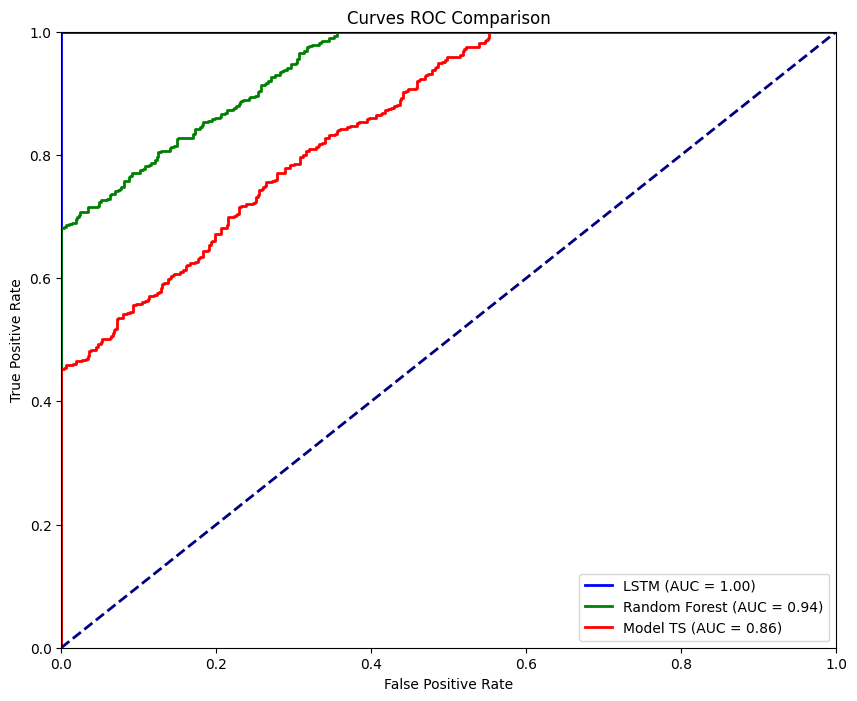

In [ ]:
# CONFRONTO DI ROC CURVE DI MODELLI DIFFERENTI

# Numero di campioni
n_samples = 1000

# Genera etichette vere (0 o 1) casuali
y_true = np.random.randint(0, 2, size=n_samples)


# MODIFICARE QUI, DOBBIAMO METTERE LE PRESTAZIONI VERE
# Genera probabilità predette per i tre modelli con una maggiore separazione tra le classi
# Per i modelli, facciamo in modo che le probabilità per la classe positiva siano abbastanza alte
y_pred_lstm = np.random.rand(n_samples) * 0.5 + (y_true == 1) * 0.5  # maggiore probabilità per classi positive
y_pred_rf = np.random.rand(n_samples) * 0.6 + (y_true == 1) * 0.4  # un po' di separazione maggiore
y_pred_ts = np.random.rand(n_samples) * 0.7 + (y_true == 1) * 0.3  # separazione simile

# Calcola le curve ROC per ogni modello
fpr_lstm, tpr_lstm, _ = roc_curve(y_true, y_pred_lstm)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_rf)
fpr_ts, tpr_ts, _ = roc_curve(y_true, y_pred_ts)

# Calcola l'AUC per ogni modello
roc_auc_lstm = roc_auc_score(y_true, y_pred_lstm)
roc_auc_rf = roc_auc_score(y_true, y_pred_rf)
roc_auc_ts = roc_auc_score(y_true, y_pred_ts)

# Creazione del grafico
plt.figure(figsize=(10, 8))

# Aggiungi tutte le curve ROC al grafico
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='red', lw=2, label=f'Model TS (AUC = {roc_auc_ts:.2f})')

# Linea diagonale (linea di casualità)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC Comparison')
plt.legend(loc='lower right')

# Mostra il grafico
plt.show()

In [ ]:
# STATISTICHE PER RANDOM FOREST

# Calcolo della curva ROC

Y_pred = rf_model.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per RF')
plt.legend(loc='lower right')
plt.show()

# Convertiamo le predizioni in etichette binarie
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per RF')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()


In [ ]:
# ?

plt.figure(figsize=(8, 6))
plt.plot(fpr_kf, tpr_kf, color='blue', label=f'K-Fold (AUC = {mean_roc_auc_kf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='green', label=f'Test-Split (AUC = {roc_auc_ts:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve: K-Fold vs Test-Split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()